In [502]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', None)

Loading BokehJS ...

### Notebook purpose: 
1. Perform NLP data preprocessing on ABC News Headline [dataset](!https://www.kaggle.com/rajmehra03/topic-modelling-using-lda-and-lsa-in-sklearn/data)
1. Implement topic modeling using LDA / LSA algorithms included in nltk packages

In [1]:
!pip install nltk spacy gensim textblob bokeh plotly pyLDAvis

     |████████████████████████████████| 24.1 MB 20.5 MB/s eta 0:00:01


In [41]:
import sys
sys.path.append('/Users/Administrator/DS/DeepRoad/Object_Detection')
sys.path.append('/Users/phil0/DS/DeepRoad/Object_Detection')
import utils2
from importlib import reload
reload(utils2)
from utils2 import *

In [15]:
raw_data = pd.read_csv('data/abcnews-date-text.csv', parse_dates=[0], infer_datetime_format=True)
reindexed_data = raw_data['headline_text']
reindexed_data.index = raw_data['publish_date']
show1(raw_data)
raw_data.head()

(1103663, 2) <class 'pandas.core.frame.DataFrame'>


,publish_date,headline_text
0,2003-02-19,aba decides against community broadcasting lic...
1,2003-02-19,act fire witnesses must be aware of defamation
2,2003-02-19,a g calls for infrastructure protection summit
3,2003-02-19,air nz staff in aust strike for pay rise
4,2003-02-19,air nz strike to affect australian travellers


### EDA

Initiated with figsize (16, 8)


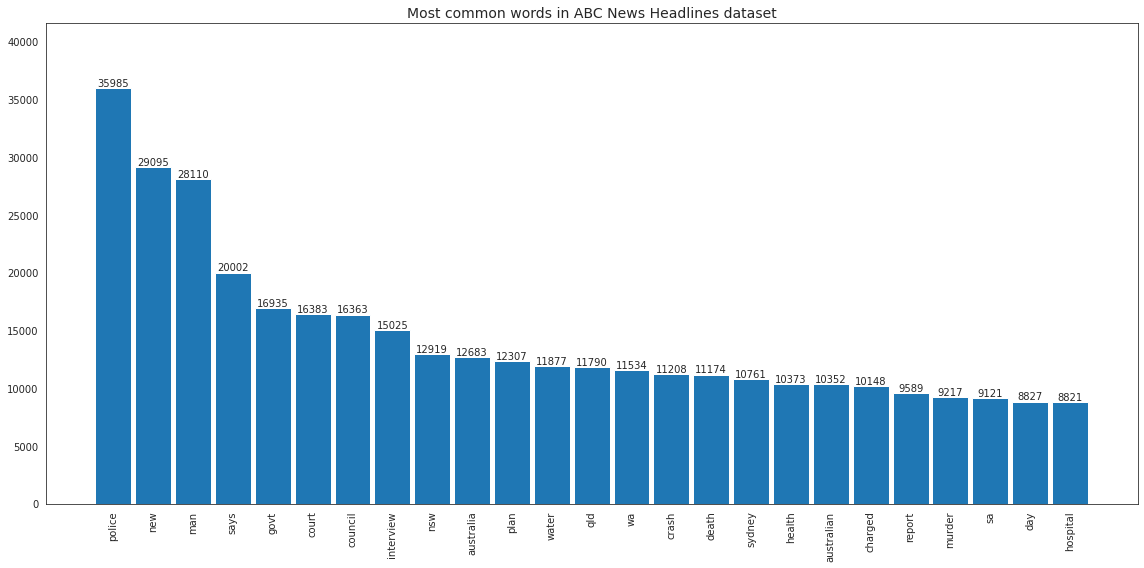

In [118]:
import sys
sys.path.append('/Users/Administrator/DS/DeepRoad/Object_Detection')
sys.path.append('/Users/phil0/DS/DeepRoad/Object_Detection')
import utils2
from importlib import reload
reload(utils2)
from utils2 import *

df1 = pd.DataFrame({'word_values':word_values, 'words':words})
viz1 = Viz(df = df1, figsize = (16,8))
fig, ax = viz1.make_barplot(x = 'words', height = 'word_values', barwidth = 0.9, ylim_scalefactor = 1.1, hline = False, vline = False, barh = False, label_adj = 1, annots = True, title = ('Most common words in ABC News Headlines dataset',14),
                           xticklabels = df1['words'], xticklocs = range(len(df1['words'])), rotation = 90)

In [23]:
import nltk
nltk.download('punkt','averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [26]:
tagged_headlines = [TextBlob(reindexed_data[i]).pos_tags for i in range(reindexed_data.shape[0])]

In [28]:
tagged_headlines_df = pd.DataFrame({'tags':tagged_headlines})

word_counts = [] 
pos_counts = {}

for headline in tagged_headlines_df[u'tags']:
    word_counts.append(len(headline))
    for tag in headline:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1
            
print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per headline: ', np.mean(word_counts))

Total number of words:  7079565
Mean number of words per headline:  6.414607538714264


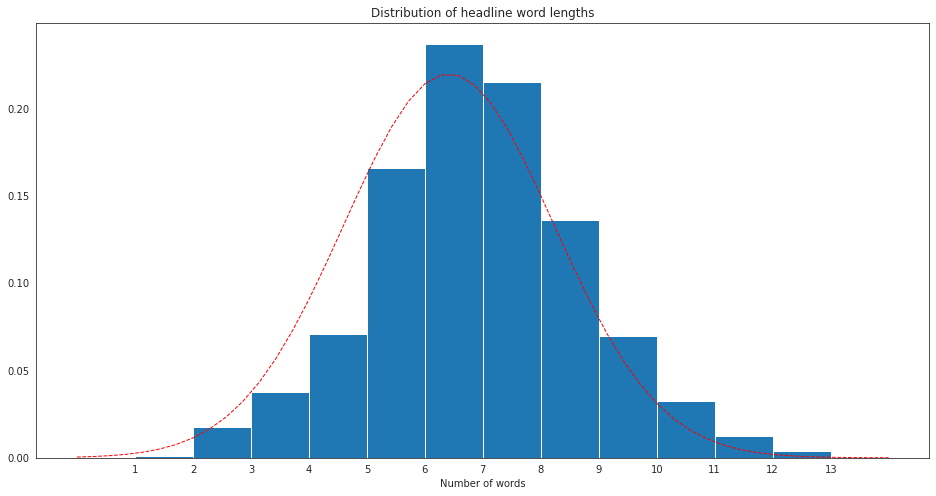

In [628]:
y = stats.norm.pdf(np.linspace(0,14,50), np.mean(word_counts), np.std(word_counts))

fig, ax = plt.subplots(figsize=(16,8))
ax.hist(word_counts, bins=range(1,14), density=True);
ax.plot(np.linspace(0,14,50), y, 'r--', linewidth=1);
ax.set_title('Distribution of headline word lengths');
ax.set_xticks(range(1,14));
ax.set_xlabel('Number of words');
plt.show()

In [529]:
headline_char_lenghts = []
for headline in raw_data['headline_text']:
    headline_char_lenghts.append(len(headline))
print(sum(headline_char_lenghts) / len(headline_char_lenghts))

40.18403987449067


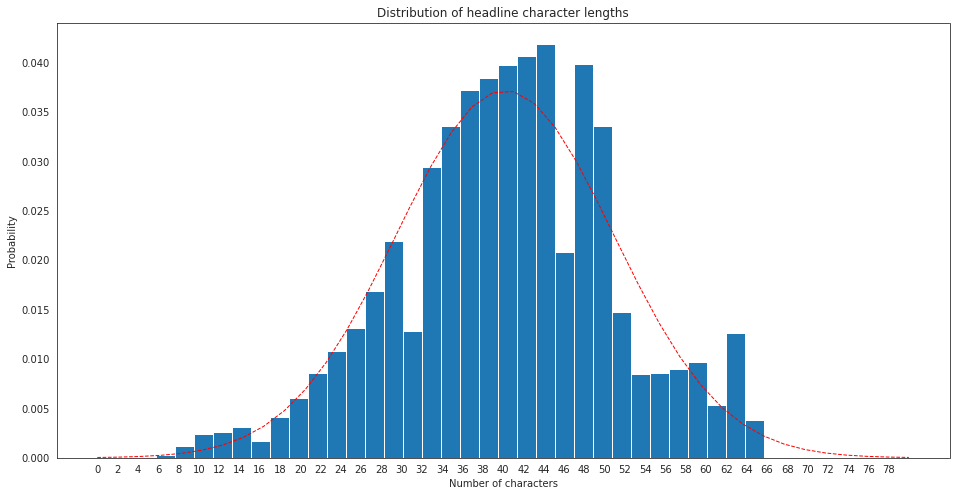

In [635]:
y = stats.norm.pdf(np.linspace(0,80,40), np.mean(headline_char_lenghts), np.std(headline_char_lenghts))

fig, ax = plt.subplots(figsize=(16,8))
ax.hist(headline_char_lenghts, bins=40, density=True);
ax.plot(np.linspace(0,80,40), y, 'r--', linewidth=1);
ax.set_title('Distribution of headline character lengths');
ax.set_xticks(range(0,80,2));
ax.set_xlabel('Number of characters');
ax.set_ylabel('Probability')
plt.show()

Initiated with figsize (16, 8)


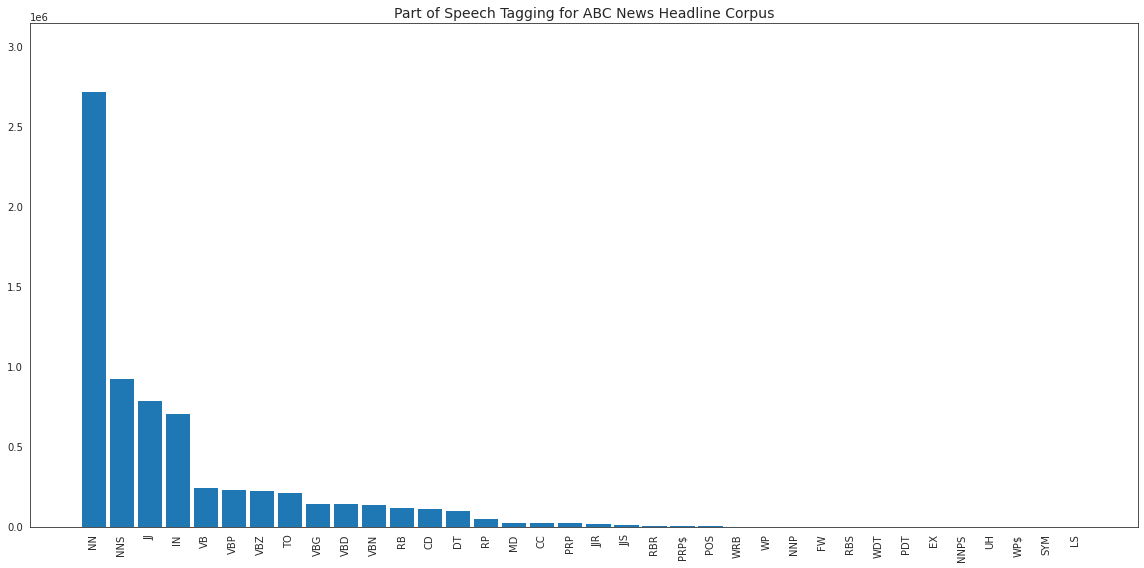

In [495]:
pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)
df_pos = pd.DataFrame({'pos_sorted_types':pos_sorted_types, 'pos_sorted_counts':pos_sorted_counts})
viz2 = Viz(df = df_pos, figsize = (16,8))
fig, ax = viz2.make_barplot(x = 'pos_sorted_types', height = 'pos_sorted_counts', barwidth = 0.9, ylim_scalefactor = 1.1, hline = False, vline = False, barh = False, label_adj = 1, annots = False, 
                            title = ('Part of Speech Tagging for ABC News Headline Corpus',14), xticklabels = df_pos['pos_sorted_types'], xticklocs = range(len(df_pos['pos_sorted_types'])), rotation = 90)

Initiated with figsize (18, 16)


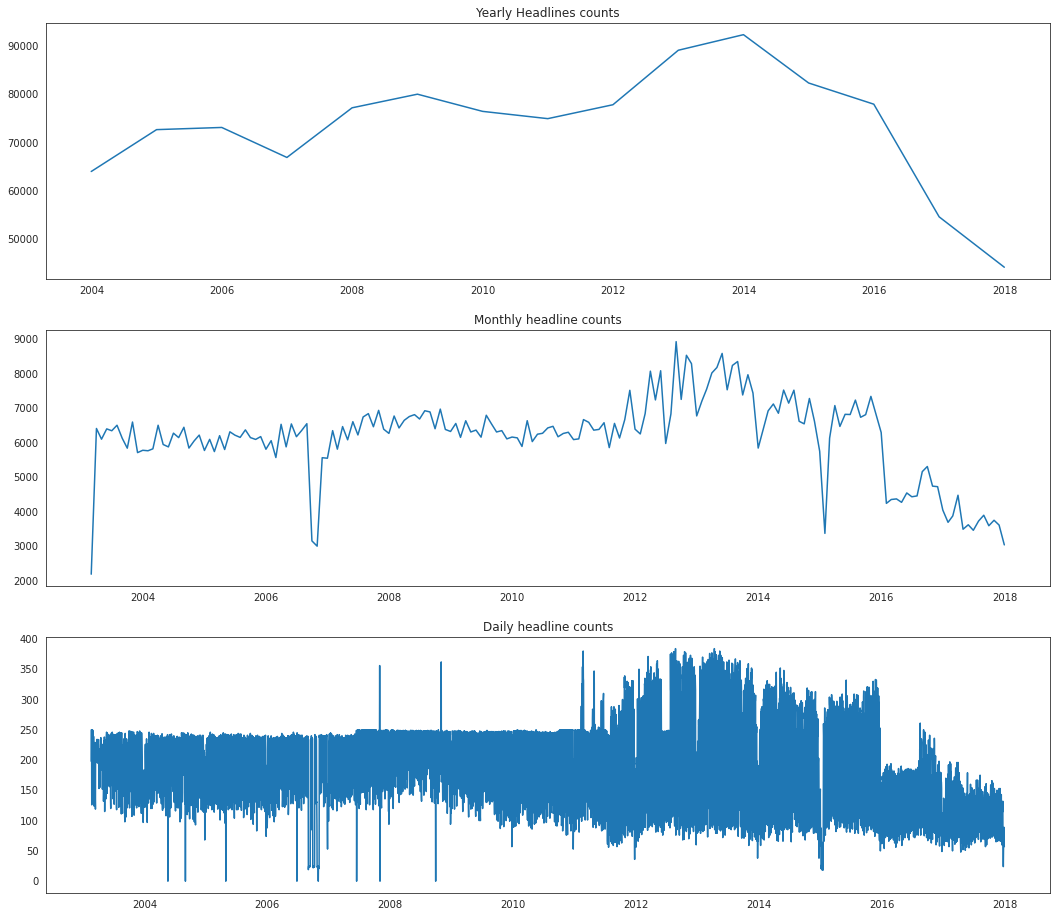

In [637]:
import sys
sys.path.append('/Users/Administrator/DS/DeepRoad/Object_Detection')
sys.path.append('/Users/phil0/DS/DeepRoad/Object_Detection')
import utils2
from importlib import reload
reload(utils2)
from utils2 import *

monthly_counts = reindexed_data.resample('M').count()
yearly_counts = reindexed_data.resample('A').count()
daily_counts = reindexed_data.resample('D').count()

viz3 = Viz(figsize = (18, 16))
viz3.get_subplots(yearly_counts, monthly_counts, daily_counts, nplots = 3, titles = ('Yearly Headlines counts', 'Monthly headline counts', 'Daily headline counts'))

In [546]:
raw_data['publish_date_minus1w'] = pd.to_datetime(raw_data['publish_date']) - pd.to_timedelta(7, unit='d')
raw_datag = raw_data.groupby([pd.Grouper(key='publish_date_minus1w', freq='W-MON')])['headline_text'].count().reset_index().sort_values('publish_date_minus1w')

In [567]:
def get_seasonality_series(df, groupby_col, val_col):
    dfg = df.groupby(groupby_col)[val_col].count().reset_index()
    series = dfg[val_col]
    series.index = dfg[groupby_col]
    return series

raw_data2 = raw_data.copy(deep = True)
raw_data2['month'] = raw_data2['publish_date'].dt.month
raw_data2['weekday'] = raw_data2['publish_date'].dt.weekday
raw_data2['day'] = raw_data2['publish_date'].dt.day

months_series = get_seasonality_series(raw_data2, groupby_col = 'month', val_col = 'headline_text')
weekday_series = get_seasonality_series(raw_data2, groupby_col = 'weekday', val_col = 'headline_text')
day_series = get_seasonality_series(raw_data2, groupby_col = 'day', val_col = 'headline_text')
print(months_series)

month
1     81011
2     85940
3     97776
4     91775
5     96740
6     92296
7     95926
8     98509
9     89357
10    94558
11    93889
12    85886
Name: headline_text, dtype: int64


In [561]:
raw_datag = raw_data.groupby(pd.Grouper(key='publish_date', freq='M'))['headline_text'].count().reset_index().sort_values('publish_date')
raw_datag['month'] = raw_datag['publish_date'].dt.month
raw_datag_months = raw_datag.groupby('month')['headline_text'].sum().reset_index()
months_series = raw_datag_months['headline_text']
months_series.index = raw_datag_months['month']
months_series

raw_datag['day'] = raw_datag['publish_date'].dt.day
raw_datag_day = raw_datag.groupby('month')['headline_text'].sum().reset_index()
months_series = raw_datag_months['headline_text']
months_series.index = raw_datag_months['month']
months_series

month
1     81011
2     85940
3     97776
4     91775
5     96740
6     92296
7     95926
8     98509
9     89357
10    94558
11    93889
12    85886
Name: headline_text, dtype: int64

Initiated with figsize (18, 16)


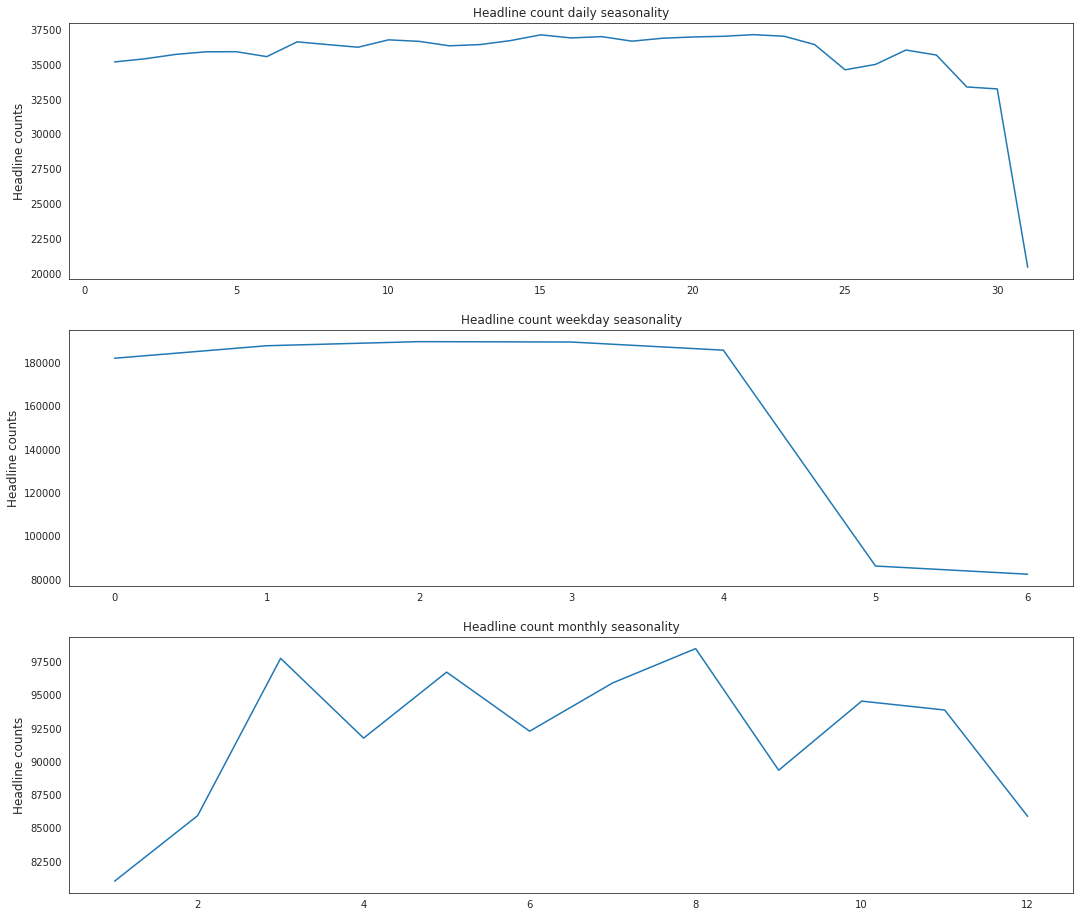

In [580]:
import sys
sys.path.append('/Users/Administrator/DS/DeepRoad/Object_Detection')
sys.path.append('/Users/phil0/DS/DeepRoad/Object_Detection')
import utils2
from importlib import reload
reload(utils2)
from utils2 import *

viz6 = Viz(figsize = (18, 16))
viz6.get_subplots(day_series, weekday_series, months_series, nplots = 3, titles = ('Headline count daily seasonality', 'Headline count weekday seasonality', 'Headline count monthly seasonality'), ylabel = ('Headline counts',12))

In [ ]:
import sys
sys.path.append('/Users/Administrator/DS/DeepRoad/Object_Detection')
sys.path.append('/Users/phil0/DS/DeepRoad/Object_Detection')
import utils2
from importlib import reload
reload(utils2)
from utils2 import *

monthly_counts = reindexed_data.resample('M').count()
yearly_counts = reindexed_data.resample('A').count()
daily_counts = reindexed_data.resample('D').count()

viz3 = Viz(figsize = (18, 16))
viz3.get_subplots(daily_counts, monthly_counts, yearly_counts, nplots = 3, titles = ('Daily Headlines counts', 'Monthly headline counts', 'Yearly headline counts'))

### Data preprocessing approaches
We experiment with various data preprocessing approaches to find out which is the most appropriate for our use case. We test:
1. Using sklearn CountVectorizer to remove stopwords only - no stemming or lemmatization involved 
1. Use nltk lemmatization, stemming and stopwords removal functions to 

Finally we train LDA, LSA, LSI and HDP models and visualize these with t-SNE to better understand how well separated various topics are 

#### Data preprocessing Approach 1: Using sklearn CountVectorizer to remove stopwords - no stemming or lemmatization involved
Adapting code from https://www.kaggle.com/rcushen/topic-modelling-with-lsa-and-lda/notebook

In [486]:
import sys
sys.path.append('/Users/Administrator/DS/DeepRoad/Object_Detection')
sys.path.append('/Users/phil0/DS/DeepRoad/Object_Detection')
import utils2
from importlib import reload
reload(utils2)
from utils2 import *

small_text_sample = reindexed_data.sample(n=10000, random_state=0).values
counter_vectorizer, document_term_matrix = words2vec(data = small_text_sample, max_features = 40000)

print('Before preprocessing ', small_text_sample[1])
print('Words converted to vector ', document_term_matrix[1])
print('Word vector inverse transformed to word output ', inv_transform_count_vectorizer(counter_vectorizer, document_term_matrix[1]))

0.1 sec to complete <function words2vec at 0x7f198e234a60>
Before preprocessing  four freed from car crash in ocean reef
Words converted to vector    (0, 4549)	1
  (0, 2014)	1
  (0, 2854)	1
  (0, 7721)	1
  (0, 9074)	1
Word vector inverse transformed to word output  [array(['freed', 'car', 'crash', 'ocean', 'reef'], dtype='<U17')]


#### LSA

In [159]:
lsa_model = TruncatedSVD(n_components=8)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

In [161]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [205]:
top_n_words_lsa = get_top_words(n = 15, n_topics = 8, keys = lsa_keys, document_term_matrix = document_term_matrix, count_vectorizer = counter_vectorizer)
for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

1.6 sec to complete <function get_top_words at 0x7f198f6f5160>
Topic 1:  police death probe missing car drug woman search fatal attack shooting assault man investigate case
Topic 2:  man charged murder jailed dies court accused guilty arrested bail woman canberra stabbing death pleads
Topic 3:  new laws year cancer years queensland sets trial zealand centre york hope opens set ceo
Topic 4:  says wa government group school claims help power minister plans mp labor funding opposition support
Topic 5:  court face accused high trial sex charges ban told faces case set challenge hears murder
Topic 6:  govt qld urged sa plan hospital work act vic boost funds closer defends cut considers
Topic 7:  council election plan water takes centre calls backs fears business lake park residents start brisbane
Topic 8:  interview australia health nsw report world china coast win australian wins sydney cup day killed


In [224]:
lsa_categories = [7, 4, 3, 0, 6, 1, 2, 5]

1.4 sec to complete <function get_top_words at 0x7f190d7d1790>
Initiated with figsize (16, 8)


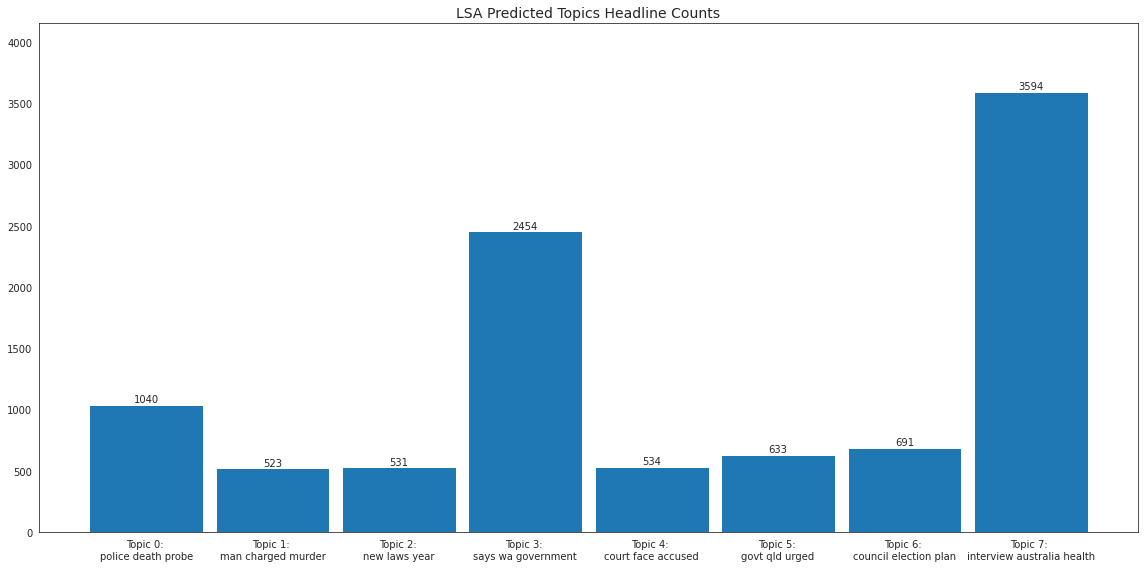

In [639]:
top_3_words = get_top_words(n = 3, n_topics = 8, keys = lsa_keys, document_term_matrix = document_term_matrix, count_vectorizer = counter_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

df2 = pd.DataFrame({'lsa_categories':lsa_categories, 'lsa_counts':lsa_counts})
df2.sort_values(by = 'lsa_categories', axis = 0, inplace = True)
labels.sort()
viz4 = Viz(df = df2, figsize = (16,8))
fig, ax = viz4.make_barplot(x = 'lsa_categories', height = 'lsa_counts', barwidth = 0.9, ylim_scalefactor = 1.1, hline = False, vline = False, barh = False, label_adj = 1, annots = True, 
                            title = ('LSA Predicted Topics Headline Counts',14), xticklabels = labels, xticklocs = range(len(labels)), rotation = 0)

In [230]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100,  n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.006s...
[t-SNE] Computed neighbors for 10000 samples in 0.568s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000974
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.206757
[t-SNE] KL divergence after 2000 iterations: 1.219305


In [233]:
n_topics = 8

In [234]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [238]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], text=top_3_words[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)

Low level of separability - moving on to LDA to see if we can get better results

#### LDA

In [488]:
lda_model_sklearn = LatentDirichletAllocation(n_components=n_topics, learning_method='online', random_state=0, verbose=0)
lda_topic_matrix_sklearn = lda_model_sklearn.fit_transform(document_term_matrix)

In [489]:
lda_keys_sklearn = get_keys(lda_topic_matrix_sklearn)
lda_categories_sklearn, lda_counts_sklearn = keys_to_counts(lda_keys_sklearn)

In [490]:
top_n_words_lda_sklearn = get_top_words(n = 15, n_topics = n_topics, keys = lda_keys_sklearn, document_term_matrix = document_term_matrix, count_vectorizer = counter_vectorizer)
for i in range(len(top_n_words_lda_sklearn)):
    print("Topic {}: ".format(i+1), top_n_words_lda_sklearn[i])

1.6 sec to complete <function get_top_words at 0x7f198e234820>
Topic 1:  police child calls day court says abuse dead change market missing climate claims nt vic
Topic 2:  council court coast murder gold government face says national police iraq drug man case news
Topic 3:  man charged police nsw sydney home road hit crash guilty jailed melbourne centre new pleads
Topic 4:  says wa death sa abc australian report open sex final laws mp action opposition safety
Topic 5:  new qld election ban country future trial end industry hour pay port dies company cancer
Topic 6:  interview australia world cup china south accused pm hill work rain jail ahead push team
Topic 7:  police health govt hospital plan boost car minister school house probe help wins set regional
Topic 8:  new water killed high attack public farmers funding police urged years charges continue woman oil


1.3 sec to complete <function get_top_words at 0x7f198e9884c0>
Initiated with figsize (16, 8)


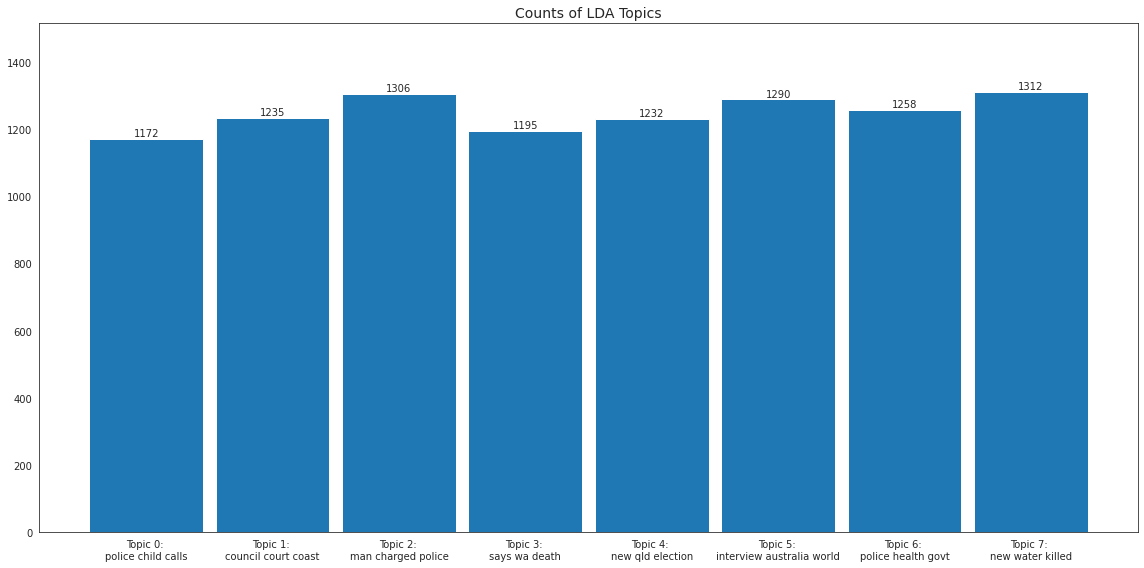

In [491]:
import sys
sys.path.append('/Users/Administrator/DS/DeepRoad/Object_Detection')
sys.path.append('/Users/phil0/DS/DeepRoad/Object_Detection')
import utils2
from importlib import reload
reload(utils2)
from utils2 import *


top_3_words_lda = get_top_words(n = 3, n_topics = 8, keys = lda_keys_sklearn, document_term_matrix = document_term_matrix, count_vectorizer = counter_vectorizer)
labels_sklearn = ['Topic {}: \n'.format(i) + top_3_words_lda[i] for i in lda_categories_sklearn]

df2 = pd.DataFrame({'lda_categories_sklearn':lda_categories_sklearn, 'lda_counts_sklearn':lda_counts_sklearn})
df2.sort_values(by = 'lda_categories_sklearn', axis = 0, inplace = True)
labels_sklearn.sort()
viz4 = Viz(df = df2, figsize = (16,8))
fig, ax = viz4.make_barplot(x = 'lda_categories_sklearn', height = 'lda_counts_sklearn', barwidth = 0.9, ylim_scalefactor = 1.1, hline = False, vline = False, barh = False, label_adj = 1, annots = True, 
                            title = ('Counts of LDA Topics',14), xticklabels = labels_sklearn, xticklocs = range(len(labels_sklearn)), rotation = 0)

In [496]:
import sys
sys.path.append('/Users/Administrator/DS/DeepRoad/Object_Detection')
sys.path.append('/Users/phil0/DS/DeepRoad/Object_Detection')
import utils2
from importlib import reload
reload(utils2)
from utils2 import *

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

tsne_lda_model_sklearn = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors_sklearn = tsne_lda_model.fit_transform(lda_topic_matrix_sklearn)

lda_mean_topic_vectors_sklearn = get_mean_topic_vectors(lda_keys_sklearn, tsne_lda_vectors_sklearn, n_topics = 8)
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors_sklearn[:,0], y=tsne_lda_vectors_sklearn[:,1], color=colormap[lda_keys_sklearn])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors_sklearn[t][0], y=lda_mean_topic_vectors_sklearn[t][1], text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.007s...
[t-SNE] Computed neighbors for 10000 samples in 0.707s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.756142
[t-SNE] KL divergence after 2000 iterations: 1.224056


In [631]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors_sklearn[:,0], y=tsne_lda_vectors_sklearn[:,1], color= 'blue')
show(plot)

Better separated topics overall - moving on to scaling LDA 

### Scaling up LDA

In [261]:
import sys
sys.path.append('/Users/Administrator/DS/DeepRoad/Object_Detection')
sys.path.append('/Users/phil0/DS/DeepRoad/Object_Detection')
import utils2
from importlib import reload
reload(utils2)
from utils2 import *

big_sample_size = 100000
big_text_sample = reindexed_data.sample(n=big_sample_size, random_state=0).values
big_count_vectorizer, big_document_term_matrix = words2vec(data = big_text_sample, max_features = 40000)

print('Before preprocessing ', big_text_sample[1])
print('Words converted to vector ', big_document_term_matrix[1])
print('Word vector inverse transformed to word output ', inv_transform_count_vectorizer(big_count_vectorizer, big_document_term_matrix[1]))

0.5 sec to complete <function words2vec at 0x7f198e468550>
Before preprocessing  four freed from car crash in ocean reef
Words converted to vector    (0, 13367)	1
  (0, 6212)	1
  (0, 8591)	1
  (0, 23181)	1
  (0, 26920)	1
Word vector inverse transformed to word output  [array(['freed', 'car', 'crash', 'ocean', 'reef'], dtype='<U18')]


In [263]:
#fit scaled up LDA model
big_lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online')
big_lda_model.fit(big_document_term_matrix)

LatentDirichletAllocation(learning_method='online', n_components=8)

In [273]:
import sys
sys.path.append('/Users/Administrator/DS/DeepRoad/Object_Detection')
sys.path.append('/Users/phil0/DS/DeepRoad/Object_Detection')
import utils2
from importlib import reload
reload(utils2)
from utils2 import *

yearly_data = []
for i in range(2003,2017+1):
    yearly_data.append(reindexed_data['{}'.format(i)].values)
    
yearly_topic_matrices = []
for year in yearly_data:
    document_term_matrix = big_count_vectorizer.transform(year)
    topic_matrix = big_lda_model.transform(document_term_matrix)
    yearly_topic_matrices.append(topic_matrix)

yearly_keys = []
for topic_matrix in yearly_topic_matrices:
    yearly_keys.append(get_keys(topic_matrix))
    
yearly_counts = []
for keys in yearly_keys:
    categories, counts = keys_to_counts(keys)
    yearly_counts.append(counts)

yearly_topic_counts = pd.DataFrame(np.array(yearly_counts), index=range(2003,2017+1))
yearly_topic_counts.columns = ['Topic {}'.format(i+1) for i in range(n_topics)]

yearly_topic_counts.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
2003,7647,9078,8147,8976,7985,7578,7658,6934
2004,7575,9025,10425,9757,8559,10220,8293,8820
2005,8398,8080,10476,8402,9423,8855,10727,8763
2006,8285,7743,7682,10008,7597,8820,7269,9508
2007,8747,8518,8181,12479,10013,10720,9832,8702


Initiated with figsize (16, 10)


(<Figure size 1152x720 with 1 Axes>, <AxesSubplot:>)

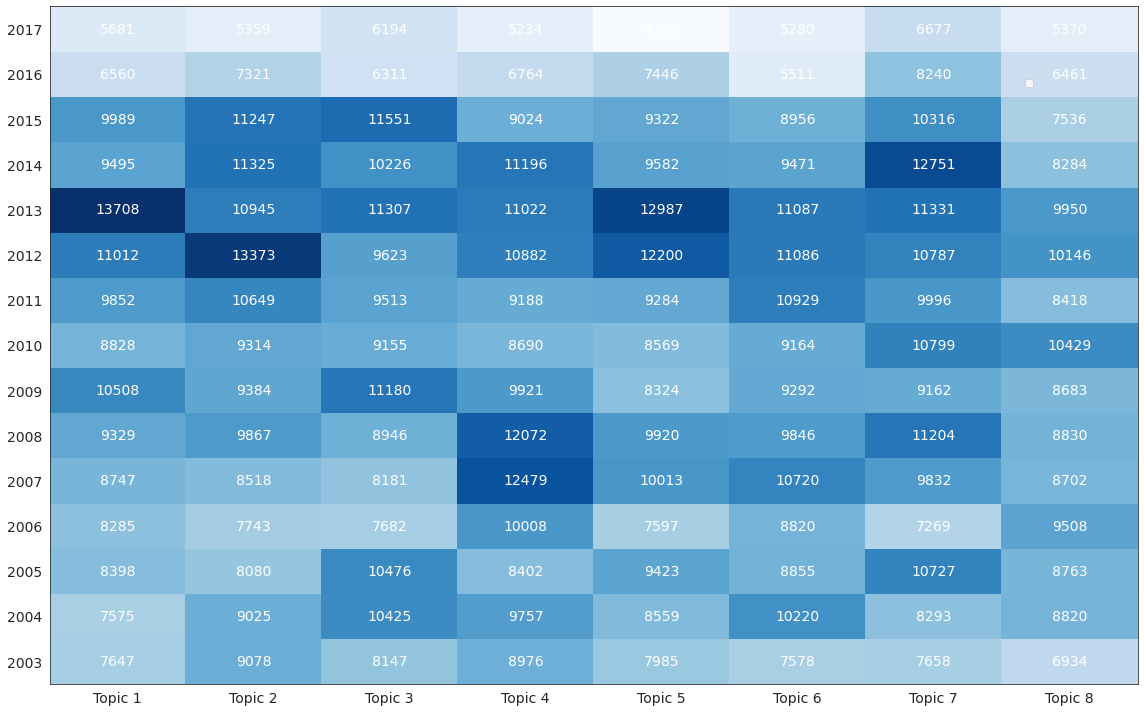

In [297]:
import sys
sys.path.append('/Users/Administrator/DS/DeepRoad/Object_Detection')
sys.path.append('/Users/phil0/DS/DeepRoad/Object_Detection')
import utils2
from importlib import reload
reload(utils2)
from utils2 import *

viz5 = Viz(figsize = (16,10))
viz5.make_corrheatmap(df = yearly_topic_counts, rotation = 0)

In [584]:
yearly_topic_counts.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
2003,7647,9078,8147,8976,7985,7578,7658,6934
2004,7575,9025,10425,9757,8559,10220,8293,8820
2005,8398,8080,10476,8402,9423,8855,10727,8763
2006,8285,7743,7682,10008,7597,8820,7269,9508
2007,8747,8518,8181,12479,10013,10720,9832,8702


Initiated with figsize (10, 6)


(<Figure size 720x432 with 1 Axes>, <AxesSubplot:>)

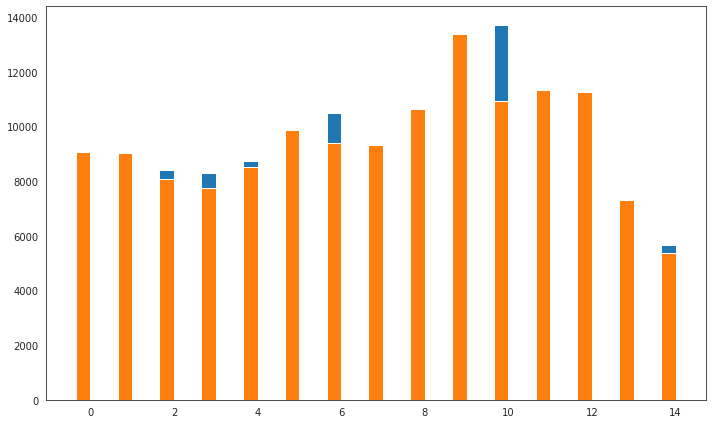

In [603]:
import sys
sys.path.append('/Users/Administrator/DS/DeepRoad/Object_Detection')
sys.path.append('/Users/phil0/DS/DeepRoad/Object_Detection')
import utils2
from importlib import reload
reload(utils2)
from utils2 import *

viz6 = Viz(df = yearly_topic_counts)
viz6.make_grouped_barplot('Topic 1', 'Topic 2', groups = yearly_topic_counts.index)

In [626]:
yearly_topic_counts2 = yearly_topic_counts.reset_index()
yearly_topic_counts2.rename({'index':'year'}, axis = 1, inplace = True)

<AxesSubplot:title={'center':'Topic Frequencies over time'}, xlabel='Year', ylabel='Headline Counts'>

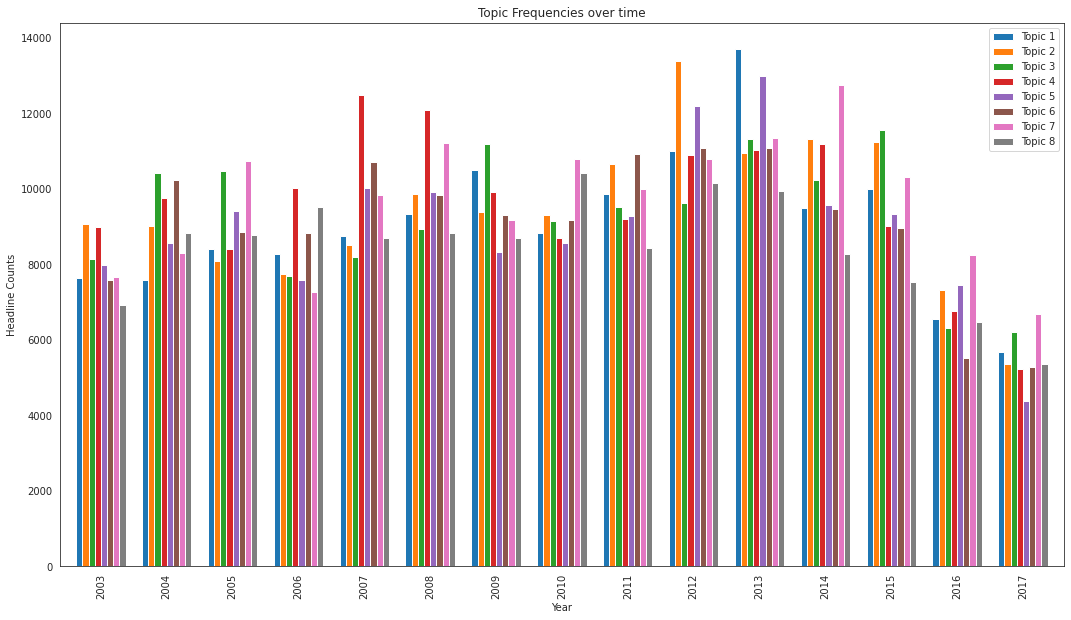

In [625]:
# plot grouped bar chart
yearly_topic_counts2.plot(x='year', kind='bar',stacked=False ,title='Topic Frequencies over time', figsize = (18,10), width = 0.75,
                         xlabel = 'Year', ylabel = 'Headline Counts')

#### Data preprocessing Approach 2: Using the NLTK library to lemmatize and stem our words and the Gensim library to remove stopwords
Adapting code from https://github.com/susanli2016/NLP-with-Python/blob/master/LDA_news_headlines.ipynb

In [298]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [301]:
print(WordNetLemmatizer().lemmatize('went', pos='v'))

go


In [302]:
stemmer = SnowballStemmer('english')
original_words = ['caresses', 'flies', 'dies', 'mules', 'denied','died', 'agreed', 'owned', 'humbled', 'sized','meeting', 'stating', 'siezing', 'itemization','sensational', 
           'traditional', 'reference', 'colonizer','plotted']
singles = [stemmer.stem(plural) for plural in original_words]
pd.DataFrame(data = {'original word': original_words, 'stemmed': singles})

,original word,stemmed
0,caresses,caress
1,flies,fli
2,dies,die
3,mules,mule
4,denied,deni
5,died,die
6,agreed,agre
7,owned,own
8,humbled,humbl
9,sized,size


In [308]:
doc_sample = raw_data[raw_data.index == 4310]['headline_text'].values[0]

print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(lemmatize_stem_remove_stopwords(doc_sample))

original document: 
['rain', 'helps', 'dampen', 'bushfires']


 tokenized and lemmatized document: 
['rain', 'help', 'dampen', 'bushfir']


In [321]:
# raw_data_sample = raw_data.sample(n = 10000)
processed_docs = raw_data['headline_text'].map(lemmatize_stem_remove_stopwords)

In [322]:
processed_docs

publish_date
2003-02-19                [decid, communiti, broadcast, licenc]
2003-02-19                                   [wit, awar, defam]
2003-02-19               [call, infrastructur, protect, summit]
2003-02-19                          [staff, aust, strike, rise]
2003-02-19                 [strike, affect, australian, travel]
                                    ...                        
2017-12-31    [ash, smith, warner, near, miss, liven, box, t...
2017-12-31                  [timelaps, brisban, year, firework]
2017-12-31                               [mean, kid, australia]
2017-12-31                     [papodopoulo, meet, mean, ausus]
2017-12-31           [georg, papadopoulo, trump, campaign, aid]
Name: headline_text, Length: 1103663, dtype: object

In [415]:
processed_docs2 = [] 
for processed_doc in processed_docs:
    processed_docs2.append(processed_doc)
processed_docs2

[['decid', 'communiti', 'broadcast', 'licenc'],
 ['wit', 'awar', 'defam'],
 ['call', 'infrastructur', 'protect', 'summit'],
 ['staff', 'aust', 'strike', 'rise'],
 ['strike', 'affect', 'australian', 'travel'],
 ['ambiti', 'olsson', 'win', 'tripl', 'jump'],
 ['antic', 'delight', 'record', 'break', 'barca'],
 ['aussi', 'qualifi', 'stosur', 'wast', 'memphi', 'match'],
 ['aust', 'address', 'secur', 'council', 'iraq'],
 ['australia', 'lock', 'timet'],
 ['australia', 'contribut', 'million', 'iraq'],
 ['barca', 'record', 'robson', 'celebr', 'birthday'],
 ['bathhous', 'plan', 'ahead'],
 ['hop', 'launceston', 'cycl', 'championship'],
 ['plan', 'boost', 'paroo', 'water', 'suppli'],
 ['blizzard', 'buri', 'unit', 'state', 'bill'],
 ['brigadi', 'dismiss', 'report', 'troop', 'harass'],
 ['british', 'combat', 'troop', 'arriv', 'daili', 'kuwait'],
 ['bryant', 'lead', 'laker', 'doubl', 'overtim'],
 ['bushfir', 'victim', 'urg', 'centrelink'],
 ['busi', 'prepar', 'terrorist', 'attack'],
 ['calleri', 'aven

In [323]:
#dictionary containing the mapping of all words, a.k.a tokens to their unique integer id
bowdict = gensim.corpora.Dictionary(processed_docs)
bowdict.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [bowdict.doc2bow(doc) for doc in processed_docs]
bow_corpus[4310]

[(76, 1), (112, 1), (483, 1), (4014, 1)]

In [324]:
bow_doc_4310 = bow_corpus[4310]

for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], bowdict[bow_doc_4310[i][0]], bow_doc_4310[i][1]))

Word 76 ("bushfir") appears 1 time.
Word 112 ("help") appears 1 time.
Word 483 ("rain") appears 1 time.
Word 4014 ("dampen") appears 1 time.


In [326]:
from gensim import corpora, models

#what is tfidf https://monkeylearn.com/blog/what-is-tf-idf/
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
for doc in corpus_tfidf:
    print(doc)
    break

[(0, 0.5892908867507543), (1, 0.38929654337861147), (2, 0.4964985175717023), (3, 0.5046520327464028)]


#### Running LDA using BOW

In [468]:
lda_model_gensim = gensim.models.LdaMulticore(bow_corpus, num_topics=n_topics, id2word=bowdict, passes=2, workers=2)
for idx, topic in lda_model_gensim.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.027*"trump" + 0.017*"say" + 0.014*"south" + 0.010*"minist" + 0.010*"state" + 0.009*"china" + 0.008*"polit" + 0.008*"close" + 0.008*"call" + 0.008*"vote"
Topic: 1 
Words: 0.034*"australian" + 0.032*"australia" + 0.020*"world" + 0.016*"open" + 0.014*"countri" + 0.014*"elect" + 0.012*"hour" + 0.011*"year" + 0.010*"share" + 0.009*"market"
Topic: 2 
Words: 0.027*"queensland" + 0.014*"water" + 0.013*"break" + 0.011*"return" + 0.011*"citi" + 0.011*"busi" + 0.010*"news" + 0.010*"royal" + 0.009*"john" + 0.008*"take"
Topic: 3 
Words: 0.017*"canberra" + 0.017*"coast" + 0.014*"hospit" + 0.013*"rise" + 0.012*"price" + 0.011*"peopl" + 0.011*"gold" + 0.010*"victoria" + 0.010*"fall" + 0.009*"show"
Topic: 4 
Words: 0.036*"polic" + 0.021*"charg" + 0.017*"death" + 0.016*"murder" + 0.014*"court" + 0.013*"woman" + 0.013*"crash" + 0.012*"die" + 0.012*"alleg" + 0.011*"kill"
Topic: 5 
Words: 0.012*"turnbul" + 0.012*"australia" + 0.009*"win" + 0.009*"port" + 0.008*"island" + 0.008*"trial" + 

In [469]:
print(processed_docs[4310])
for index, score in sorted(lda_model_gensim[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))

['rain', 'help', 'dampen', 'bushfir']

Score: 0.469108909368515	 
Topic: 0.032*"trump" + 0.014*"donald" + 0.013*"turnbul" + 0.012*"island" + 0.011*"life" + 0.010*"sentenc" + 0.009*"darwin" + 0.009*"port" + 0.008*"futur" + 0.008*"say"

Score: 0.3808111250400543	 
Topic: 0.018*"world" + 0.012*"australia" + 0.012*"open" + 0.011*"win" + 0.010*"year" + 0.010*"coast" + 0.010*"final" + 0.010*"record" + 0.009*"adelaid" + 0.009*"gold"

Score: 0.02501961588859558	 
Topic: 0.024*"govern" + 0.020*"elect" + 0.017*"south" + 0.014*"market" + 0.014*"australian" + 0.013*"countri" + 0.012*"live" + 0.012*"rural" + 0.010*"west" + 0.010*"share"

Score: 0.025017207488417625	 
Topic: 0.034*"australia" + 0.012*"warn" + 0.011*"leagu" + 0.010*"kill" + 0.010*"near" + 0.009*"vote" + 0.009*"north" + 0.008*"test" + 0.008*"violenc" + 0.008*"continu"

Score: 0.025014830753207207	 
Topic: 0.037*"polic" + 0.022*"charg" + 0.021*"court" + 0.016*"murder" + 0.015*"death" + 0.014*"woman" + 0.014*"crash" + 0.014*"face" + 0.0

In [476]:
import sys
sys.path.append('/Users/Administrator/DS/DeepRoad/Object_Detection')
sys.path.append('/Users/phil0/DS/DeepRoad/Object_Detection')
import utils2
from importlib import reload
reload(utils2)
from utils2 import *

# unseen_documents = ['How a Pentagon deal became an identity crisis for Google','We are all happy']
headlines_raw = list(raw_data['headline_text'][:10000])
bow_vectors = [bowdict.doc2bow(lemmatize_stem_remove_stopwords(unseen_document)) for unseen_document in headlines_raw]
#gensim
lda_topic_predictions_gensim = [lda_model_gensim[bow_vector] for bow_vector in bow_vectors]

In [477]:
topic_preds = []
for doc in lda_topic_predictions_gensim:
    topics = []
    for topic_prediction in doc:
        topics.append(topic_prediction[1])
    topic_preds.append(topics)

In [478]:
lda_topic_matrix_gensim = np.array(topic_preds)

In [425]:
tsne_lda_model2 = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors2 = tsne_lda_model2.fit_transform(lda_topic_matrix_gensim)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.006s...
[t-SNE] Computed neighbors for 10000 samples in 0.676s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000464
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.479294
[t-SNE] KL divergence after 2000 iterations: 0.786942


In [426]:
print(tsne_lda_vectors.shape)
print(tsne_lda_vectors2.shape)

(10000, 2)
(10000, 2)


In [427]:
lda_keys2 = get_keys(lda_topic_matrix_gensim)
lda_categories2, lda_counts2 = keys_to_counts(lda_keys2)
lda_mean_topic_vectors2 = get_mean_topic_vectors(lda_keys2, tsne_lda_vectors2)

In [428]:
#plotting tsne on our bow-trained LDA

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors2[:,0], y=tsne_lda_vectors2[:,1], color=colormap[lda_keys2])

show(plot)

In [505]:
#seeing if updating number of passes yields better results
passes = 5
lda_model_gensim = gensim.models.LdaMulticore(bow_corpus, num_topics=n_topics, id2word=bowdict, passes=passes, workers=2)
for idx, topic in lda_model_gensim.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))
    
import sys
sys.path.append('/Users/Administrator/DS/DeepRoad/Object_Detection')
sys.path.append('/Users/phil0/DS/DeepRoad/Object_Detection')
import utils2
from importlib import reload
reload(utils2)
from utils2 import *

# unseen_documents = ['How a Pentagon deal became an identity crisis for Google','We are all happy']
headlines_raw = list(raw_data['headline_text'][:10000])
bow_vectors = [bowdict.doc2bow(lemmatize_stem_remove_stopwords(unseen_document)) for unseen_document in headlines_raw]
#gensim
lda_topic_predictions_gensim = [lda_model_gensim[bow_vector] for bow_vector in bow_vectors]


topic_preds = []
for doc in lda_topic_predictions_gensim:
    topics = []
    for topic_prediction in doc:
        topics.append(topic_prediction[1])
    topic_preds.append(topics)
    

lda_topic_matrix_gensim = np.array(topic_preds)

tsne_lda_model2 = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors2 = tsne_lda_model2.fit_transform(lda_topic_matrix_gensim)

lda_keys2 = get_keys(lda_topic_matrix_gensim)
lda_categories2, lda_counts2 = keys_to_counts(lda_keys2)
lda_mean_topic_vectors2 = get_mean_topic_vectors(lda_keys2, tsne_lda_vectors2)


#plotting tsne on our bow-trained LDA

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors2[:,0], y=tsne_lda_vectors2[:,1], color=colormap[lda_keys2])

show(plot)

/opt/conda/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


Topic: 0 
Words: 0.026*"charg" + 0.025*"sydney" + 0.025*"court" + 0.020*"polic" + 0.019*"murder" + 0.016*"face" + 0.014*"alleg" + 0.013*"jail" + 0.013*"accus" + 0.012*"drug"
Topic: 1 
Words: 0.026*"trump" + 0.026*"year" + 0.019*"world" + 0.019*"australia" + 0.015*"open" + 0.015*"canberra" + 0.014*"test" + 0.013*"final" + 0.010*"turnbul" + 0.010*"time"
Topic: 2 
Words: 0.021*"govern" + 0.018*"elect" + 0.016*"plan" + 0.012*"council" + 0.011*"state" + 0.011*"health" + 0.011*"fund" + 0.010*"nation" + 0.009*"school" + 0.009*"labor"
Topic: 3 
Words: 0.015*"market" + 0.014*"live" + 0.012*"rural" + 0.012*"rise" + 0.011*"power" + 0.011*"price" + 0.011*"fight" + 0.011*"share" + 0.010*"break" + 0.010*"communiti"
Topic: 4 
Words: 0.024*"queensland" + 0.020*"south" + 0.019*"north" + 0.017*"coast" + 0.015*"australia" + 0.014*"china" + 0.013*"tasmania" + 0.011*"gold" + 0.010*"flood" + 0.009*"polit"
Topic: 5 
Words: 0.020*"adelaid" + 0.017*"warn" + 0.016*"countri" + 0.013*"donald" + 0.013*"hour" + 0.0

Initiated with figsize (16, 8)


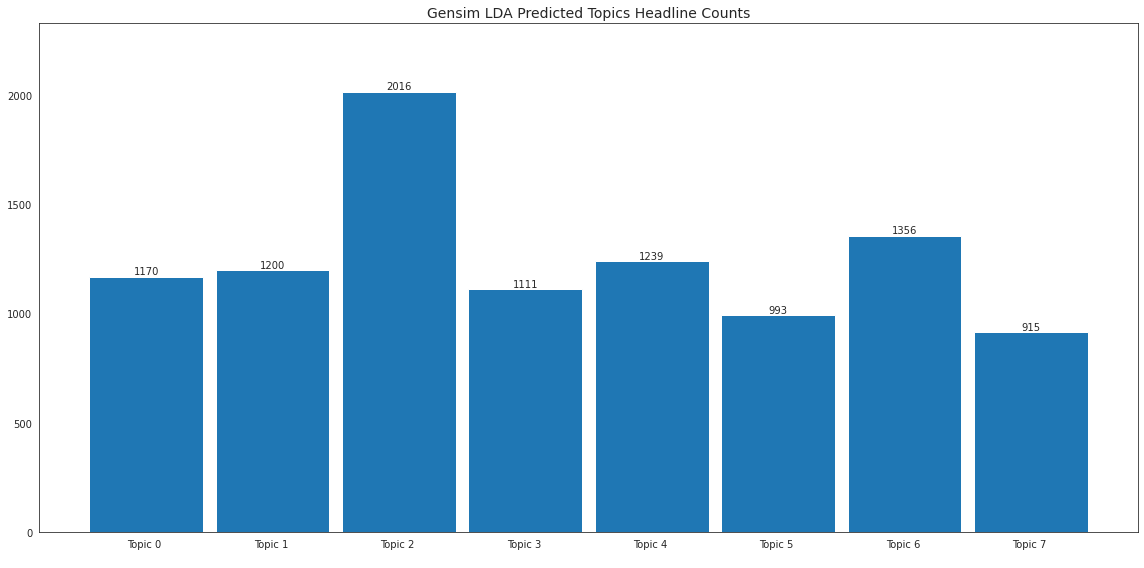

In [640]:
import sys
sys.path.append('/Users/Administrator/DS/DeepRoad/Object_Detection')
sys.path.append('/Users/phil0/DS/DeepRoad/Object_Detection')
import utils2
from importlib import reload
reload(utils2)
from utils2 import *


# top_3_words_lda = get_top_words(n = 3, n_topics = 8, keys = lda_keys, document_term_matrix = document_term_matrix, count_vectorizer = counter_vectorizer)
labels2 = ['Topic {} \n'.format(i) for i in lda_categories2]

df3 = pd.DataFrame({'lda_categories2':lda_categories2, 'lda_counts2':lda_counts2})
df3.sort_values(by = 'lda_categories2', axis = 0, inplace = True)
labels2.sort()
viz4 = Viz(df = df3, figsize = (16,8))
fig, ax = viz4.make_barplot(x = 'lda_categories2', height = 'lda_counts2', barwidth = 0.9, ylim_scalefactor = 1.1, hline = False, vline = False, barh = False, label_adj = 1, annots = True, 
                            title = ('Gensim LDA Predicted Topics Headline Counts',14), xticklabels = labels2, xticklocs = range(len(labels2)), rotation = 0)

#### Running LDA using tfidf

In [332]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=n_topics, id2word=bowdict, passes=2, workers=2)
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.017*"council" + 0.016*"plan" + 0.016*"health" + 0.014*"hour" + 0.012*"servic" + 0.012*"chang" + 0.011*"fall" + 0.011*"state" + 0.009*"green" + 0.009*"john"
Topic: 1 
Words: 0.016*"say" + 0.015*"call" + 0.012*"school" + 0.009*"farmer" + 0.009*"protest" + 0.008*"budget" + 0.008*"labor" + 0.008*"forc" + 0.008*"student" + 0.008*"tasmanian"
Topic: 2 
Words: 0.032*"trump" + 0.014*"donald" + 0.013*"turnbul" + 0.012*"island" + 0.011*"life" + 0.010*"sentenc" + 0.009*"darwin" + 0.009*"port" + 0.008*"futur" + 0.008*"say"
Topic: 3 
Words: 0.034*"australia" + 0.012*"warn" + 0.011*"leagu" + 0.010*"kill" + 0.010*"near" + 0.009*"vote" + 0.009*"north" + 0.008*"test" + 0.008*"violenc" + 0.008*"continu"
Topic: 4 
Words: 0.037*"polic" + 0.022*"charg" + 0.021*"court" + 0.016*"murder" + 0.015*"death" + 0.014*"woman" + 0.014*"crash" + 0.014*"face" + 0.012*"die" + 0.011*"perth"
Topic: 5 
Words: 0.026*"queensland" + 0.016*"interview" + 0.015*"report" + 0.014*"tasmania" + 0.014*"power" + 0.01

In [334]:
for index, score in sorted(lda_model_tfidf[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.8247321844100952	 
Topic: 0.017*"queensland" + 0.011*"donald" + 0.009*"turnbul" + 0.007*"coast" + 0.007*"south" + 0.007*"royal" + 0.006*"australia" + 0.006*"hill" + 0.006*"weather" + 0.006*"commiss"

Score: 0.025081569328904152	 
Topic: 0.014*"interview" + 0.010*"news" + 0.007*"grandstand" + 0.007*"hobart" + 0.007*"sexual" + 0.007*"plead" + 0.006*"march" + 0.005*"clinton" + 0.005*"fire" + 0.005*"spring"

Score: 0.025066997855901718	 
Topic: 0.010*"market" + 0.008*"live" + 0.007*"share" + 0.006*"australian" + 0.006*"michael" + 0.005*"peter" + 0.005*"price" + 0.005*"australia" + 0.005*"dollar" + 0.005*"know"

Score: 0.02506118454039097	 
Topic: 0.012*"countri" + 0.011*"hour" + 0.010*"govern" + 0.007*"health" + 0.005*"fund" + 0.005*"marriag" + 0.005*"say" + 0.005*"energi" + 0.005*"communiti" + 0.004*"plan"

Score: 0.025018401443958282	 
Topic: 0.014*"polic" + 0.014*"charg" + 0.012*"murder" + 0.011*"woman" + 0.009*"death" + 0.009*"court" + 0.009*"crash" + 0.008*"alleg" + 0.008*"c

In [433]:
from gensim import corpora, models

headlines_raw = list(raw_data['headline_text'][:10000])
bow_vectors = [bowdict.doc2bow(lemmatize_stem_remove_stopwords(unseen_document)) for unseen_document in headlines_raw]

#what is tfidf https://monkeylearn.com/blog/what-is-tf-idf/
tfidf2 = models.TfidfModel(bow_vectors)
corpus_tfidf2 = tfidf2[bow_vectors]
for doc in corpus_tfidf[:10]:
    print(doc)
    break

[(0, 0.5892908867507543), (1, 0.38929654337861147), (2, 0.4964985175717023), (3, 0.5046520327464028)]


In [434]:
#gensim
lda_topic_predictions_tfidf = [lda_model_tfidf[bow_vector] for bow_vector in bow_vectors]

#plotting tsne on our bow-trained LDA
topic_preds2 = []
for doc in lda_topic_predictions_tfidf:
    topics = []
    for topic_prediction in doc:
        topics.append(topic_prediction[1])
    topic_preds2.append(topics)
    
lda_topic_matrix_tfidf = np.array(topic_preds2)

In [436]:
tsne_lda_model_tfidf = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors_tfidf = tsne_lda_model_tfidf.fit_transform(lda_topic_matrix_tfidf)

lda_keys_tfidf = get_keys(lda_topic_matrix_tfidf)
lda_categories_tfidf, lda_counts_tfidf = keys_to_counts(lda_keys_tfidf)
lda_mean_topic_vectors_tfidf = get_mean_topic_vectors(lda_keys_tfidf, tsne_lda_vectors_tfidf)

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors_tfidf[:,0], y=tsne_lda_vectors_tfidf[:,1], color=colormap[lda_keys_tfidf])

# for t in range(n_topics):
#     label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], text=top_3_words_lda[t], text_color=colormap[t])
#     plot.add_layout(label)

show(plot)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.006s...
[t-SNE] Computed neighbors for 10000 samples in 0.593s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000136
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.907516
[t-SNE] KL divergence after 2000 iterations: 0.549570


Initiated with figsize (16, 8)


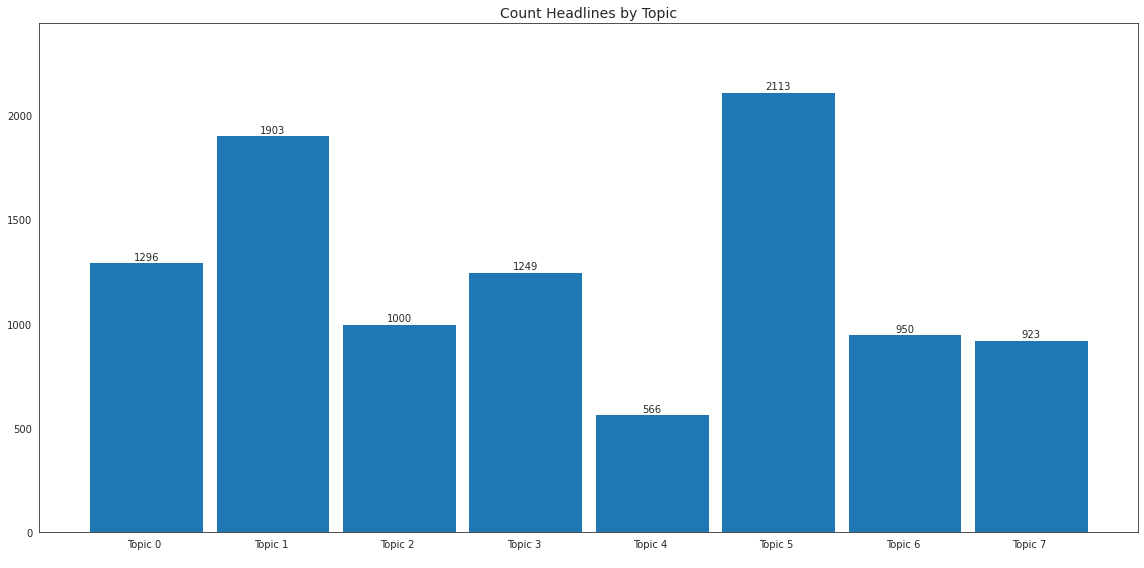

In [441]:
import sys
sys.path.append('/Users/Administrator/DS/DeepRoad/Object_Detection')
sys.path.append('/Users/phil0/DS/DeepRoad/Object_Detection')
import utils2
from importlib import reload
reload(utils2)
from utils2 import *


# top_3_words_lda = get_top_words(n = 3, n_topics = 8, keys = lda_keys, document_term_matrix = document_term_matrix, count_vectorizer = counter_vectorizer)
labels_tfidf = ['Topic {} \n'.format(i) for i in lda_categories_tfidf]

df_tfidf = pd.DataFrame({'lda_categories_tfidf':lda_categories_tfidf, 'lda_counts_tfidf':lda_counts_tfidf})
df_tfidf.sort_values(by = 'lda_categories_tfidf', axis = 0, inplace = True)
labels_tfidf.sort()
viz_tfidf = Viz(df = df_tfidf, figsize = (16,8))
fig, ax = viz_tfidf.make_barplot(x = 'lda_categories_tfidf', height = 'lda_counts_tfidf', barwidth = 0.9, ylim_scalefactor = 1.1, hline = False, vline = False, barh = False, label_adj = 1, annots = True, 
                            title = ('Count Headlines by Topic',14), xticklabels = labels_tfidf, xticklocs = range(len(labels_tfidf)), rotation = 0)

#### Unseen document 

In [337]:
unseen_document = 'How a Pentagon deal became an identity crisis for Google'
bow_vector = bowdict.doc2bow(lemmatize_stem_remove_stopwords(unseen_document))

for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.3319035470485687	 Topic: 0.032*"trump" + 0.014*"donald" + 0.013*"turnbul" + 0.012*"island" + 0.011*"life"
Score: 0.20970599353313446	 Topic: 0.024*"govern" + 0.020*"elect" + 0.017*"south" + 0.014*"market" + 0.014*"australian"
Score: 0.18746161460876465	 Topic: 0.016*"say" + 0.015*"call" + 0.012*"school" + 0.009*"farmer" + 0.009*"protest"
Score: 0.18743640184402466	 Topic: 0.018*"world" + 0.012*"australia" + 0.012*"open" + 0.011*"win" + 0.010*"year"
Score: 0.020891675725579262	 Topic: 0.017*"council" + 0.016*"plan" + 0.016*"health" + 0.014*"hour" + 0.012*"servic"
Score: 0.020883221179246902	 Topic: 0.034*"australia" + 0.012*"warn" + 0.011*"leagu" + 0.010*"kill" + 0.010*"near"
Score: 0.02086830325424671	 Topic: 0.026*"queensland" + 0.016*"interview" + 0.015*"report" + 0.014*"tasmania" + 0.014*"power"
Score: 0.020849265158176422	 Topic: 0.037*"polic" + 0.022*"charg" + 0.021*"court" + 0.016*"murder" + 0.015*"death"


In [338]:
unseen_document = 'We are all happy living in a yellow submarine'
bow_vector = bowdict.doc2bow(lemmatize_stem_remove_stopwords(unseen_document))

for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.4251853823661804	 Topic: 0.024*"govern" + 0.020*"elect" + 0.017*"south" + 0.014*"market" + 0.014*"australian"
Score: 0.22501538693904877	 Topic: 0.034*"australia" + 0.012*"warn" + 0.011*"leagu" + 0.010*"kill" + 0.010*"near"
Score: 0.22472736239433289	 Topic: 0.018*"world" + 0.012*"australia" + 0.012*"open" + 0.011*"win" + 0.010*"year"
Score: 0.025014379993081093	 Topic: 0.017*"council" + 0.016*"plan" + 0.016*"health" + 0.014*"hour" + 0.012*"servic"
Score: 0.025014379993081093	 Topic: 0.016*"say" + 0.015*"call" + 0.012*"school" + 0.009*"farmer" + 0.009*"protest"
Score: 0.025014379993081093	 Topic: 0.032*"trump" + 0.014*"donald" + 0.013*"turnbul" + 0.012*"island" + 0.011*"life"
Score: 0.025014379993081093	 Topic: 0.037*"polic" + 0.022*"charg" + 0.021*"court" + 0.016*"murder" + 0.015*"death"
Score: 0.025014379993081093	 Topic: 0.026*"queensland" + 0.016*"interview" + 0.015*"report" + 0.014*"tasmania" + 0.014*"power"


### LSI - Latent Semantic Indexing
Adapting code from https://www.kaggle.com/faressayah/text-analysis-topic-modelling-with-spacy-gensim

In [444]:
from gensim.models import LdaModel, CoherenceModel, LsiModel, HdpModel
# from gensim.models.wrappers import LdaMallet

In [ ]:
bowdict.shape

In [452]:
lsi_model = LsiModel(corpus=bow_vectors, num_topics=10, id2word = bowdict)
lsi_model.show_topics(num_topics=8)

[(0,
  '0.937*"iraq" + 0.179*"say" + 0.068*"troop" + 0.067*"govt" + 0.065*"missil" + 0.058*"plan" + 0.050*"report" + 0.047*"kill" + 0.046*"iraqi" + 0.045*"bomb"'),
 (1,
  '-0.860*"polic" + -0.186*"govt" + -0.156*"plan" + -0.139*"charg" + 0.131*"iraq" + -0.119*"probe" + -0.108*"protest" + -0.104*"death" + -0.080*"court" + -0.079*"anti"'),
 (2,
  '-0.683*"govt" + -0.457*"plan" + 0.338*"polic" + -0.161*"council" + 0.146*"iraq" + -0.123*"fund" + -0.116*"urg" + -0.114*"iraqi" + -0.108*"claim" + -0.092*"say"'),
 (3,
  '-0.736*"plan" + 0.587*"govt" + -0.154*"protest" + -0.153*"council" + -0.097*"anti" + -0.094*"water" + 0.061*"claim" + 0.058*"urg" + 0.055*"polic" + -0.041*"iraqi"'),
 (4,
  '0.680*"iraqi" + 0.367*"say" + 0.221*"baghdad" + -0.208*"plan" + -0.199*"govt" + 0.188*"kill" + -0.176*"iraq" + 0.119*"claim" + -0.119*"polic" + 0.118*"forc"'),
 (5,
  '0.558*"charg" + 0.458*"face" + 0.437*"court" + 0.292*"council" + -0.216*"iraqi" + -0.173*"polic" + 0.144*"murder" + -0.120*"say" + -0.104*"

### HDP - Hierarchical Dirichlet Process
Adapting code from https://www.kaggle.com/faressayah/text-analysis-topic-modelling-with-spacy-gensim

In [453]:
hdp_model = HdpModel(corpus=bow_vectors, id2word=bowdict)
hdp_model.show_topics(num_topics = 8)

[(0,
  '0.001*protest + 0.001*fatter + 0.001*illus + 0.001*threat + 0.001*say + 0.001*enter + 0.001*issu + 0.001*philli + 0.001*survey + 0.001*daintre + 0.001*ferret + 0.001*bastard + 0.001*sky + 0.001*agforc + 0.001*desex + 0.000*testimoni + 0.000*grader + 0.000*blame + 0.000*jonathan + 0.000*blade'),
 (1,
  '0.001*crossin + 0.001*bogey + 0.001*henti + 0.001*panesar + 0.001*daley + 0.001*undersea + 0.001*ricin + 0.001*creep + 0.001*kafelnikov + 0.001*gerrard + 0.001*agfest + 0.001*nosed + 0.001*chilean + 0.000*crossbench + 0.000*redknapp + 0.000*kon + 0.000*pyramid + 0.000*greer + 0.000*summernat + 0.000*scotland'),
 (2,
  '0.001*iraq + 0.001*shearer + 0.001*croatian + 0.001*iowa + 0.001*commod + 0.001*drop + 0.001*loan + 0.001*warnek + 0.001*crow + 0.001*govt + 0.000*finger + 0.000*trauma + 0.000*biosecur + 0.000*lone + 0.000*ivori + 0.000*boot + 0.000*hushovd + 0.000*tough + 0.000*culina + 0.000*ansett'),
 (3,
  '0.001*foil + 0.001*zika + 0.001*cochran + 0.001*brisban + 0.001*thirst

In [506]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
gensimvis.prepare(lda_model_gensim, bow_vectors, bowdict)

/opt/conda/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.138839  0.193906       1        1  16.996264
6     -0.285122  0.059599       2        1  12.980112
4      0.106450  0.028029       3        1  12.783637
1      0.083631 -0.278281       4        1  12.055134
0     -0.332504  0.025476       5        1  11.972086
3      0.140647  0.177240       6        1  11.717063
5      0.049329 -0.288219       7        1  10.961621
7      0.098729  0.082251       8        1  10.534083, topic_info=            Term        Freq       Total Category  logprob  loglift
16    australian  177.000000  177.000000  Default  30.0000  30.0000
235        polic  257.000000  257.000000  Default  29.0000  29.0000
319        charg  137.000000  137.000000  Default  28.0000  28.0000
6594       trump  137.000000  137.000000  Default  27.0000  27.0000
1103        year  135.000000  135.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
716         fear   21.437779   41.236806   Topic8  -5.3699   1.5964
552        futur   20.707237   37.067885   Topic8  -5.4046   1.6683
37     australia   25.258579  235.104044   Topic8  -5.2059   0.0197
1319      return   20.921657   46.230504   Topic8  -5.3943   1.4577
781       worker   20.995715   51.571144   Topic8  -5.3908   1.3519

[332 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
321       8  0.989475  aborigin
1883      5  1.006771      abus
210       5  1.002293     accus
512       3  1.004113    action
965       7  0.997162   adelaid
...     ...       ...       ...
781       5  0.193907    worker
781       8  0.407204    worker
421       4  1.003208     world
1103      4  0.996899      year
114       1  1.008162     youth

[369 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 5, 2, 1, 4, 6, 8])

/opt/conda/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


### Appendix - disregard

In [ ]:
#Viz class method template  
def make_(self, *cols, df = None, **kwargs):
        '''Method for creating a '''
        df = self.check_df(df)
        fig, ax = plt.subplots(figsize = self.figsize)
        ax = self.set_decorations(ax, **kwargs)
        
        self.download_fig(**kwargs)
        fig = ax.get_figure()
        fig.tight_layout()
        return fig, ax

In [ ]:
#gensim
lsi_topic_predictions = [lsi_model[bow_vector] for bow_vector in bow_vectors]

#plotting tsne on LSI
topic_preds2 = []
for doc in lsi_topic_predictions:
    topics = []
    for topic_prediction in doc:
        if topic_prediction[1] > 0:
            topics.append(topic_prediction[1])
        else:
            topics.append(0)
    topic_preds2.append(topics)
    
lsi_topic_matrix = np.array(topic_preds2)

tsne_lsi_model = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsi_vectors = tsne_lsi_model.fit_transform(lsi_topic_matrix)

lsi_keys = get_keys(lsi_topic_matrix)
lsi_categories, lsi_counts = keys_to_counts(lsi_keys)
lsi_mean_topic_vectors = get_mean_topic_vectors(lsi_keys, tsne_lsi_vectors)

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

plot = figure(title="t-SNE Clustering of {} LSI Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lsi_vectors[:,0], y=tsne_lsi_vectors[:,1], color=colormap[lsi_keys])

# for t in range(n_topics):
#     label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], text=top_3_words_lda[t], text_color=colormap[t])
#     plot.add_layout(label)

show(plot)